R => Python  
Source: https://web.stanford.edu/class/stats191/notebooks/Penalized_regression.html


NOTE: 
* Not exactly porting R to Python.
* Also not [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)

## Bias-variance tradeoff 

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score

In [2]:
sm.version.version

'0.9.0'

In [3]:
import scipy; scipy.__version__

'0.18.1'



- One goal of a regression analysis is to "build" a model that predicts well -- AIC / $C_p$ & Cross-validation selection criteria based on this.

- This is slightly different than the goal of making inferences about $\beta$ that we've focused on so far.

- What does "predict well" mean? 
$$
\begin{aligned}
     MSE_{pop}({{\cal M}}) &= {\mathbb{E}}\left((Y_{new} - \widehat{Y}_{new,{\cal M}}(X_{new}))^2\right) \\
     &=
     {\text{Var}}(Y_{new}) + {\text{Var}}(\widehat{Y}_{new,{\cal M}}) +
     \\
     & \qquad \quad \text{Bias}(\widehat{Y}_{new,{\cal M}})^2.
     \end{aligned}$$
 
- Can we take an estimator for a model ${\cal M}$ and make it better in terms of $MSE$?


## Shrinkage estimators: one sample problem

1. Generate $Y_{100 \times 1} \sim N(\mu \cdot 1, 5^2 I_{100 \times 100})$, with $\mu=0.5$.
2. For $0 \leq \alpha \leq 1$, set $\hat{Y}(\alpha) = \alpha \bar{Y}.$
3. Compute $MSE(\hat{Y}(\alpha)) = \frac{1}{100}\sum_{i=1}^{100} (\hat{Y}_{\alpha} - 0.5)^2$
4. Repeat 1000 times, plot average of $MSE(\hat{Y}(\alpha))$.

**For what value of $\alpha$ is $\hat{Y}(\alpha)$ unbiased?**

**Is this the best estimate of $\mu$ in terms of MSE?**

In [4]:
mu = 0.5
sigma = 5
nsample = 100
ntrial = 10000

In [5]:
def get_mse(mu_hat, mu):
    return np.sum((mu_hat - mu)**2) / len(mu)

In [6]:
alpha = np.linspace(0, 1, 20)

In [7]:
bias= (1 - alpha) * mu

In [8]:
variance = (alpha**2) * 25/100

In [9]:
mse = []
for trial in range(ntrial):
    result = []
    z = stats.norm.rvs(size=nsample) * sigma + mu
    for num in alpha:
        result.append(get_mse(num * np.mean(z) * np.ones(nsample), mu * np.ones(nsample)))
    mse.append(result)

In [10]:
mse_mean = np.mean(mse, axis=0)

In [11]:
mse_mean

array([0.25      , 0.22478138, 0.20237994, 0.18279566, 0.16602856,
       0.15207863, 0.14094587, 0.13263029, 0.12713187, 0.12445063,
       0.12458656, 0.12753967, 0.13330994, 0.14189739, 0.153302  ,
       0.16752379, 0.18456276, 0.20441889, 0.2270922 , 0.25258268])

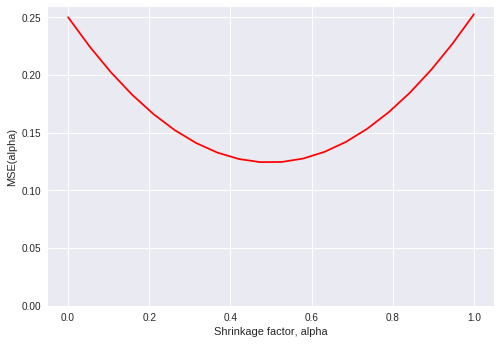

In [12]:
plt.plot(alpha, mse_mean, 'r')
plt.ylim(bottom=0)
plt.ylabel('MSE(alpha)')
plt.xlabel('Shrinkage factor, alpha')
plt.show()

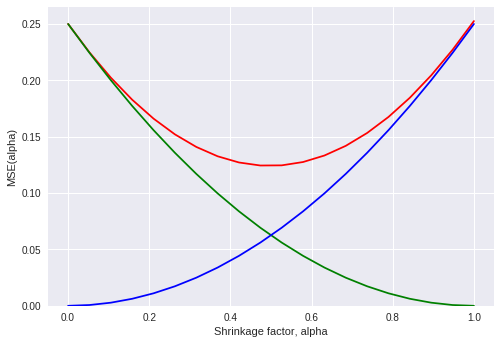

In [13]:
plt.plot(alpha, mse_mean, 'r')
plt.plot(alpha, bias**2, 'g')
plt.plot(alpha, variance, 'b')
plt.ylim(bottom=0)
plt.ylabel('MSE(alpha)')
plt.xlabel('Shrinkage factor, alpha')
plt.legend
plt.show()


## Shrinkage & Penalties

* Shrinkage can be thought of as "constrained" or "penalized" minimization.

* Constrained form:
$$\text{minimize}_{\mu} \sum_{i=1}^n (Y_i - \mu)^2 \quad \text{subject to $\mu^2 \leq C$}$$

* Lagrange multiplier form: equivalent to 
$$\widehat{\mu}_{\lambda} = \text{argmin}_{\mu} \sum_{i=1}^n (Y_i - \mu)^2 + \lambda \cdot \mu^2$$ for some $\lambda=\lambda_C$.

* As we vary $\lambda$ we solve all versions of the constrained form.

### Solving for $\widehat{\mu}_{\lambda}$

* Differentiating: $- 2 \sum_{i=1}^n (Y_i - \widehat{\mu}_{\lambda}) + 2 \lambda \widehat{\mu}_{\lambda} = 0$
* Solving $\widehat{\mu}_{\lambda} = \frac{\sum_{i=1}^n Y_i}{n + \lambda} = \frac{n}{n+\lambda} \overline{Y}.$
* As $\lambda \rightarrow 0$, $\widehat{\mu}_{\lambda} \rightarrow {\overline{Y}}.$
* As $\lambda \rightarrow \infty$ $\widehat{\mu}_{\lambda} \rightarrow 0.$

** We see that $\widehat{\mu}_{\lambda} = \bar{Y} \cdot \left(\frac{n}{n+\lambda}\right).$ **

** In other words, considering all penalized estimators traces out the
MSE curve above.**


In [14]:
lam = nsample / alpha - nsample

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [15]:
lam

array([          inf, 1800.        ,  850.        ,  533.33333333,
        375.        ,  280.        ,  216.66666667,  171.42857143,
        137.5       ,  111.11111111,   90.        ,   72.72727273,
         58.33333333,   46.15384615,   35.71428571,   26.66666667,
         18.75      ,   11.76470588,    5.55555556,    0.        ])

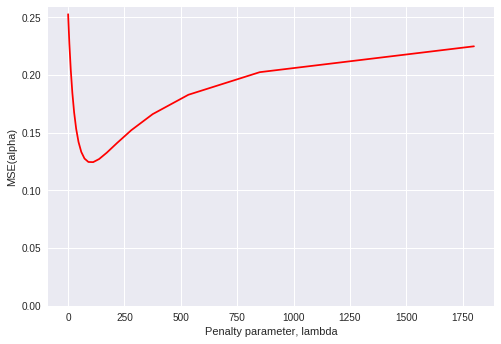

In [16]:
plt.plot(lam, mse_mean, 'r')
plt.ylim(bottom=0)
plt.ylabel('MSE(alpha)')
plt.xlabel('Penalty parameter, lambda')
plt.show()

/home/doojung/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


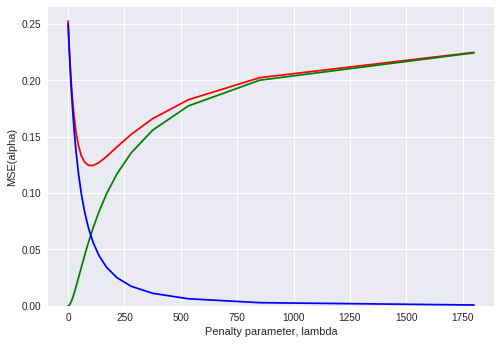

In [17]:
plt.plot(lam, mse_mean, 'r')
plt.plot(lam, bias**2, 'g')
plt.plot(lam, variance, 'b')
plt.ylim(bottom=0)
plt.ylabel('MSE(alpha)')
plt.xlabel('Penalty parameter, lambda')
plt.legend()
plt.show()

### How much to shrink?

- In our one-sample example,
- $$\begin{aligned}
 MSE_{pop}(\alpha) &=   {\text{Var}}( \alpha \bar{Y}) + \text{Bias}(\alpha \bar{Y})^2 +  \text{Var}(Y_{new})
\\
 &= \frac{\alpha^2 \sigma^2}{n} + \mu^2 (1 - \alpha)^2 +  \text{Var}(Y_{new}) 
 \end{aligned}$$
- Differentiating and solving: 
$$\begin{aligned}
 0 &= -2 \mu^2(1 - \alpha^*) + 2 \frac{\alpha^* \sigma^2}{n}  \\
 \alpha^* & = \frac{\mu^2}{\mu^2+\sigma^2/n} = \frac{(\mu/(\sigma/\sqrt{n}))^2}{(\mu/(\sigma/\sqrt{n}))^2 + 1} \\
 &= \frac{0.5^2}{0.5^2+25/100} = 0.5
 \end{aligned}$$
     
** We see that the optimal $\alpha$ depends on the unknown $SNR=\mu/(\sigma/\sqrt{n})$. Value is 1/8.**

** In practice we might hope to estimate MSE with cross-validation.**

Let's see how our theoretical choice matches the 
MSE on our 100 sample.

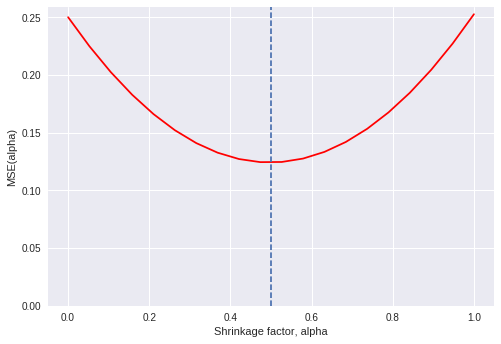

In [18]:
plt.plot(alpha, mse_mean, 'r')
plt.ylim(bottom=0)
plt.ylabel('MSE(alpha)')
plt.xlabel('Shrinkage factor, alpha')
plt.axvline(mu**2/(mu**2+sigma**2/nsample), linestyle='--')
plt.show()

### Penalties & Priors

- Minimizing $\sum_{i=1}^n (Y_i - \mu)^2 + \lambda \mu^2$ is similar to computing "MLE" of $\mu$ if the likelihood was proportional to 
$$\exp \left(-\frac{1}{2\sigma^2}\left(  \|Y-\mu\|^2_2 + \lambda \mu^2\right) \right).$$

- If $\lambda=m$, an integer, then $\widehat{\mu}_{\lambda}$ is the sample mean of $(Y_1, \dots, Y_n,0 ,\dots, 0) \in \mathbb{R}^{n+m}$.

- This is equivalent to adding some data with $Y=0$. 

- To a Bayesian,
this extra data is a *prior distribution* and we are computing the so-called
*MAP* or posterior mode.

## AIC as penalized regression

- Model selection with $C_p$ (or AIC with $\sigma^2$ assumed known)
is a version of penalized regression.

- The best subsets version of AIC (which is not exactly equivalent to *step*)
$$
\hat{\beta}_{AIC} = \text{argmin}_{\beta} \frac{1}{\sigma^2}\|Y-X\beta\|^2_2 + 2 \|\beta\|_0
$$
where
$$
\|\beta\|_0 = \#\left\{j : \beta_j \neq 0 \right\}
$$
is called the $\ell_0$ norm.

- The $\ell_0$ penalty can be thought of as a measure of *complexity* of the model. Most penalties are similar versions of *complexity*.

## Penalized regression in general

* Not all biased models are better – we need a way to find "good" biased models.

* Inference ($F$, $\chi^2$ tests, etc) is not quite exact for biased models.
Though, there has been some recent work to address the issue of [post-selection inference](http://arxiv.org/abs/1311.6238), at least for some penalized regression problems.

* Heuristically, "large $\beta$" (measured by some norm) is interpreted as "complex model". Goal is really to penalize "complex" models, i.e. Occam’s razor.
* If truth really is complex, this may not work! (But, it will then be hard to build a good model anyways ... (statistical lore))

## Ridge regression

- Assume that columns $(X_j)_{1 \leq j \leq p}$ have zero mean, and SD 1 and $Y$ has zero mean.

- This is called the *standardized model*.

- The ridge estimator is
$$
\begin{aligned}
\hat{\beta}_{\lambda} &= \text{argmin}_{\beta} \frac{1}{2n}\|Y-X\beta\|^2_2 + \frac{\lambda}{2} \|\beta\|^2_2 \\
&= \text{argmin}_{\beta} MSE_{\lambda}(\beta)
\end{aligned}
$$
  
- Corresponds (through Lagrange multiplier) to a quadratic constraint on ${\beta_{}}$’s.

- This is the natural generalization of the penalized
version of our shrinkage estimator.

### Solving the normal equations

* Normal equations $$\frac{\partial}{\partial {\beta_{l}}} MSE_{\lambda}({\beta_{}}) = - \frac{1}{n}  (Y - X{\beta_{}})^TX_l  +  \lambda {\beta_{l}}$$
* $$- \frac{1}{n}(Y - X{\widehat{\beta}_{\lambda}})^T X_l +  \lambda {\widehat{\beta}_{l,\lambda}} = 0, \qquad 1 \leq l \leq p$$
* In matrix form $$-\frac{X^TY}{n} +  \left(\frac{X^TX}{n} + \lambda I\right) {\widehat{\beta}_{\lambda}} = 0.$$
* Or $${\widehat{\beta}_{\lambda}} = \left(\frac{X^TX}{n} + \lambda I\right)^{-1} \frac{X^TY}{n}.$$


### Ridge regression

In [19]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
"""
From Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) 
"Least Angle Regression," Annals of Statistics (with discussion), 407-499, we have

"Ten baseline variables, age, sex, body mass index, average blood pressure, 
and six blood serum measurements were obtained for each of n = 442 diabetes patients, 
as well as the response of interest, a quantitative measure of disease progression one year 
after baseline."

In the tab delimited file above, the variables are named

    AGE SEX BMI BP S1 S2 S3 S4 S5 S6 Y

reference: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html
"""

'\nFrom Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) \n"Least Angle Regression," Annals of Statistics (with discussion), 407-499, we have\n\n"Ten baseline variables, age, sex, body mass index, average blood pressure, \nand six blood serum measurements were obtained for each of n = 442 diabetes patients, \nas well as the response of interest, a quantitative measure of disease progression one year \nafter baseline."\n\nIn the tab delimited file above, the variables are named\n\n    AGE SEX BMI BP S1 S2 S3 S4 S5 S6 Y\n\nreference: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html\n'

In [20]:
# Sklearn version -> Standardized: zero mean and unit L2 norm 
diabetes.data[:5]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, -0.02632783, -0.00844872,
        -0.01916334,  0.07441156, -0.03949338, -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, -0.00567061, -0.04559945,
        -0.03419447, -0.03235593, -0.00259226,  0.00286377, -0.02593034],
       [-0.08906294, -0.04464164, -0.01159501, -0.03665645,  0.01219057,
         0.02499059, -0.03603757,  0.03430886,  0.02269202, -0.00936191],
       [ 0.00538306, -0.04464164, -0.03638469,  0.02187235,  0.00393485,
         0.01559614,  0.00814208, -0.00259226, -0.03199144, -0.04664087]])

In [110]:
diabetes.data

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

In [21]:
# Sklearn version -> Standardized: zero mean and unit L2 norm 
diabetes.target[:5]

array([151.,  75., 141., 206., 135.])